In [1]:
import cv2
import numpy as np
from skimage.segmentation import slic
from skimage.color import rgb2gray
from skimage.util import img_as_float
from IPython.display import Image

Define the paths of the images

In [2]:
# Paths to the stereo images
left_paths = [
    'sawtooth/im2.ppm', 
    'venus/im2.ppm', 
    'bull/im2.ppm', 
    'poster/im2.ppm', 
    'barn1/im2.ppm', 
    'barn2/im2.ppm', 
]
right_paths = [
    'sawtooth/im6.ppm', 
    'venus/im6.ppm', 
    'bull/im6.ppm', 
    'poster/im6.ppm', 
    'barn1/im6.ppm', 
    'barn2/im6.ppm', 
]

# Paths to the disparity maps
gt_paths = [
    'sawtooth/disp2.pgm', 
    'venus/disp2.pgm', 
    'bull/disp2.pgm', 
    'poster/disp2.pgm', 
    'barn1/disp2.pgm', 
    'barn2/disp2.pgm', 
]

Loading and Preprocessing Part

In [3]:
def load_images(left_path, right_path):
    left_image = cv2.imread(left_path)
    right_image = cv2.imread(right_path)
    return left_image, right_image

# Convert grey scale and set the number type as float32 for proper numerical calculation
def preprocess_images(left_image, right_image):
    left_gray = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    right_gray = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    return left_gray, right_gray

Get the segments for the image by using SLIC

In [4]:
def segment_image(image, n_segments=200, compactness=10):
    segments = slic(img_as_float(image), n_segments=n_segments, compactness=compactness)
    return segments

def get_segment_centroids(segments):
    centroids = []
    for seg_val in np.unique(segments):
        mask = segments == seg_val  # Get the segment pixels only
        coords = np.column_stack(np.where(mask))
        centroid = coords.mean(axis=0).astype(int)  # Calculate the mean to get the centroid
        centroids.append((centroid[1], centroid[0]))  
    return centroids

It iterates over each segment in the left image to match with the right ones. It finds the segment pairs by considering epipolar constraint. Then, it calculates the distance between the centroids. The segment that has the minimum distance is the match for the left segment. We will do this until we iterate over all the segments in the left image.

In [5]:
def match_segments(left_image, right_image, left_segments, right_segments):
    left_centroids = get_segment_centroids(left_segments)
    right_centroids = get_segment_centroids(right_segments)
    
    matches = []
    for left_c in left_centroids:
        min_distance = float('inf')
        best_match = None
        for right_c in right_centroids:
            if left_c[1] == right_c[1]:  # Epipolar constraint 
                distance = np.linalg.norm(left_image[left_c[1], left_c[0]] - right_image[right_c[1], right_c[0]])
                if distance < min_distance:
                    min_distance = distance
                    best_match = right_c
        if best_match:
            matches.append((left_c, best_match))
    
    return matches

It draws matches by using the centroid info.

In [6]:
def draw_matches(left_image, right_image, matches):
    combined_image = np.hstack((left_image, right_image))
    for (left_c, right_c) in matches:
        right_c_shifted = (right_c[0] + left_image.shape[1], right_c[1])
        cv2.line(combined_image, left_c, right_c_shifted, (0, 255, 0), 1)
    return combined_image

It loads the disparity map and compare the results. The website says "a value of 100 in disp2.pgm means that the corresponding pixel in im6.ppm is 12.5 pixels to the left.” Therefore, the difference between the matched centroid coordinates should be close to this value. We will calculate the error by using Mean Absolute Error.

In [7]:
def load_ground_truth_disparity(gt_path, scale_factor=8):
    gt_disparity = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
    gt_disparity /= scale_factor
    return gt_disparity

def calculate_error_metrics(matches, disp2_ground_truth):
    total_error = 0
    for (lx, ly), (rx, ry) in matches:
        segment_shift = abs(rx - lx)
        disparity_value = disp2_ground_truth[ly, lx]
        error = abs(segment_shift - disparity_value)
        total_error += error
    
    return total_error/len(matches)

Results

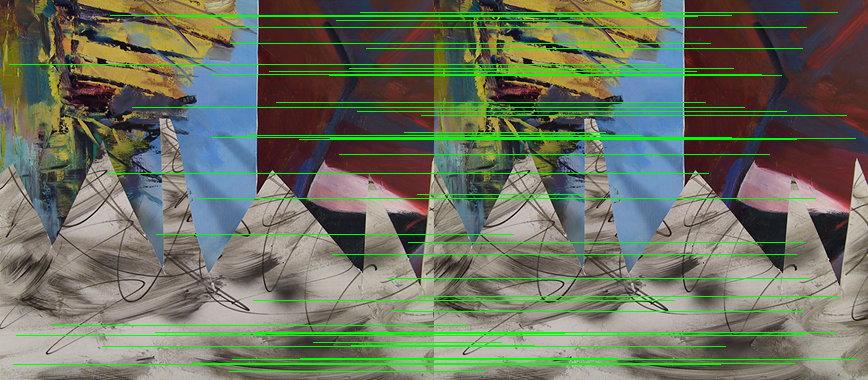

For the image sawtooth, MAE:  95.3092105263158


In [8]:
# Load images
left_image, right_image = load_images(left_paths[0], right_paths[0])

# Preprocess images (grayscale conversion)
left_gray, right_gray = preprocess_images(left_image, right_image)

# Segment images using SLIC
left_segments = segment_image(left_image)
right_segments = segment_image(right_image)

# Match segments
matches = match_segments(left_gray, right_gray, left_segments, right_segments)

# Draw matches 
matched_image = draw_matches(left_image, right_image, matches)
cv2.imwrite('stereo_matches_0.png', matched_image)
display(Image("stereo_matches_0.png"))

error = calculate_error_metrics(matches, load_ground_truth_disparity(gt_paths[0], scale_factor=8))
print(f"For the image sawtooth, MAE: ", error)

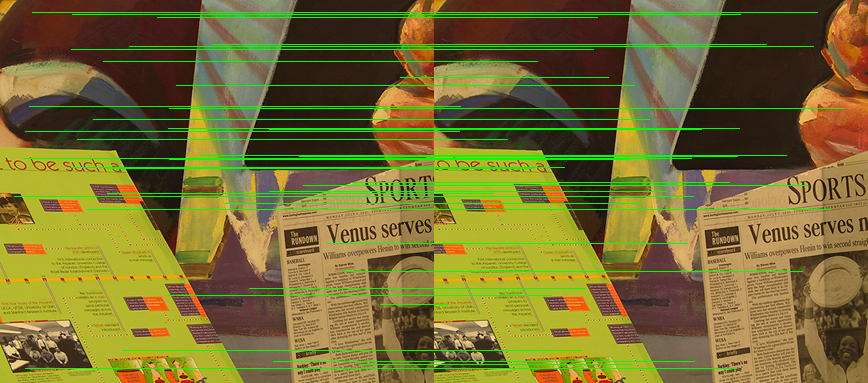

For the image venus, MAE:  91.44132653061224


In [9]:
# Load images
left_image, right_image = load_images(left_paths[1], right_paths[1])

# Preprocess images (grayscale conversion)
left_gray, right_gray = preprocess_images(left_image, right_image)

# Segment images using SLIC
left_segments = segment_image(left_image)
right_segments = segment_image(right_image)

# Match segments
matches = match_segments(left_gray, right_gray, left_segments, right_segments)

# Draw matches 
matched_image = draw_matches(left_image, right_image, matches)
cv2.imwrite(f'stereo_matches_1.png', matched_image)
display(Image("stereo_matches_1.png"))

error = calculate_error_metrics(matches, load_ground_truth_disparity(gt_paths[1], scale_factor=8))
print(f"For the image venus, MAE: ", error)

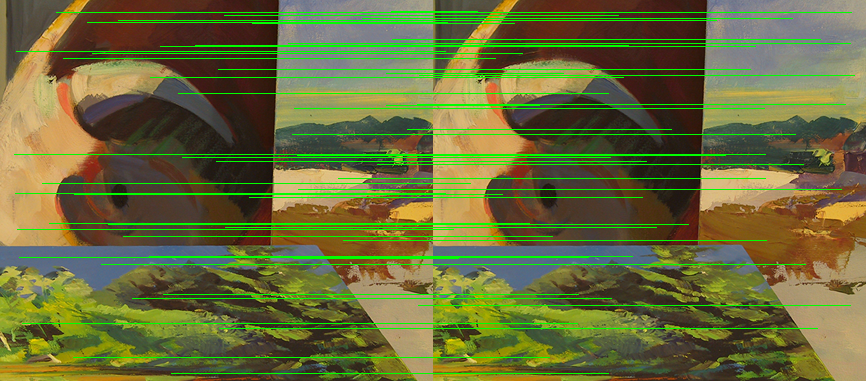

For the image bull, MAE:  77.18359375


In [10]:
# Load images
left_image, right_image = load_images(left_paths[2], right_paths[2])

# Preprocess images (grayscale conversion)
left_gray, right_gray = preprocess_images(left_image, right_image)

# Segment images using SLIC
left_segments = segment_image(left_image)
right_segments = segment_image(right_image)

# Match segments
matches = match_segments(left_gray, right_gray, left_segments, right_segments)

# Draw matches 
matched_image = draw_matches(left_image, right_image, matches)
cv2.imwrite(f'stereo_matches_2.png', matched_image)
display(Image("stereo_matches_2.png"))

error = calculate_error_metrics(matches, load_ground_truth_disparity(gt_paths[2], scale_factor=8))
print(f"For the image bull, MAE: ", error)

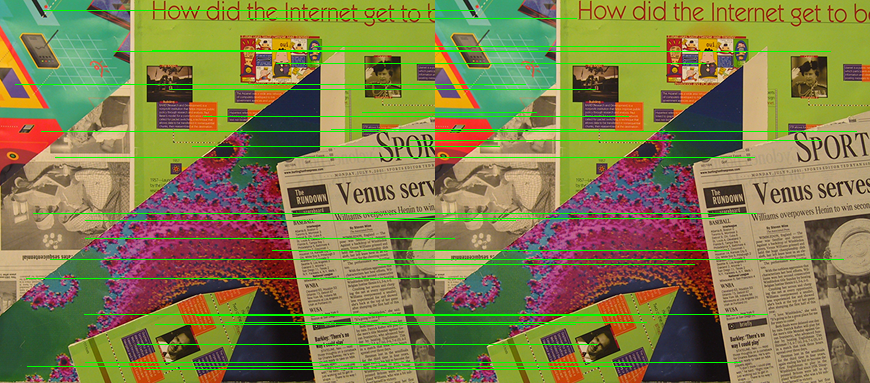

For the image poster, MAE:  107.8445945945946


In [11]:
# Load images
left_image, right_image = load_images(left_paths[3], right_paths[3])

# Preprocess images (grayscale conversion)
left_gray, right_gray = preprocess_images(left_image, right_image)

# Segment images using SLIC
left_segments = segment_image(left_image)
right_segments = segment_image(right_image)

# Match segments
matches = match_segments(left_gray, right_gray, left_segments, right_segments)

# Draw matches 
matched_image = draw_matches(left_image, right_image, matches)
cv2.imwrite(f'stereo_matches_3.png', matched_image)
display(Image("stereo_matches_3.png"))

error = calculate_error_metrics(matches, load_ground_truth_disparity(gt_paths[3], scale_factor=8))
print(f"For the image poster, MAE: ", error)

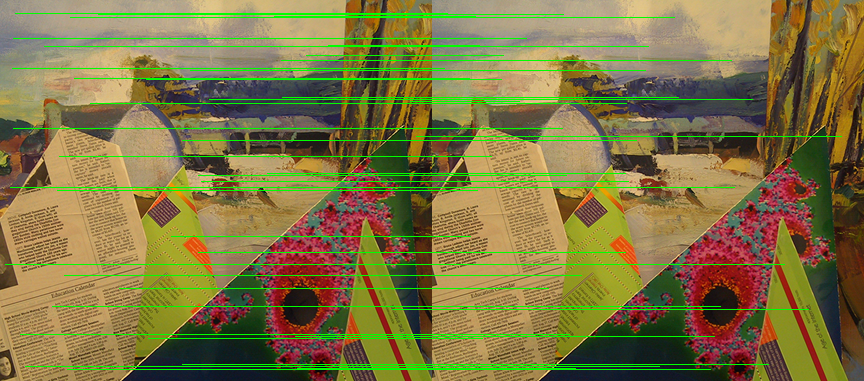

For the image barn1, MAE:  97.725


In [12]:
# Load images
left_image, right_image = load_images(left_paths[4], right_paths[4])

# Preprocess images (grayscale conversion)
left_gray, right_gray = preprocess_images(left_image, right_image)

# Segment images using SLIC
left_segments = segment_image(left_image)
right_segments = segment_image(right_image)

# Match segments
matches = match_segments(left_gray, right_gray, left_segments, right_segments)

# Draw matches 
matched_image = draw_matches(left_image, right_image, matches)
cv2.imwrite(f'stereo_matches_4.png', matched_image)
display(Image("stereo_matches_4.png"))

error = calculate_error_metrics(matches, load_ground_truth_disparity(gt_paths[4], scale_factor=8))
print(f"For the image barn1, MAE: ", error)

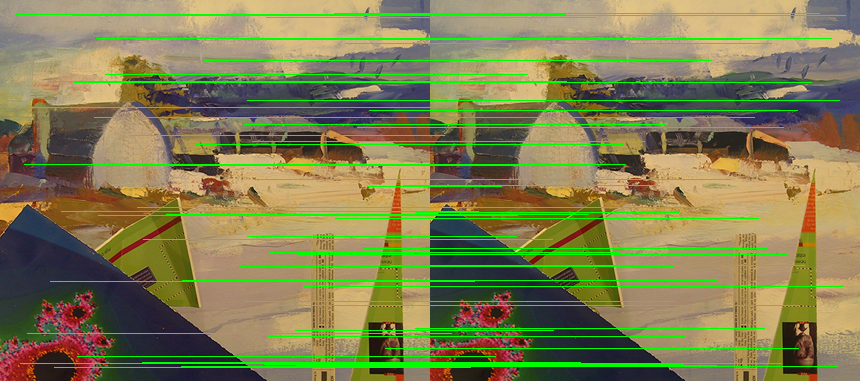

For the image barn2, MAE:  59.395833333333336


In [13]:
# Load images
left_image, right_image = load_images(left_paths[5], right_paths[5])

# Preprocess images (grayscale conversion)
left_gray, right_gray = preprocess_images(left_image, right_image)

# Segment images using SLIC
left_segments = segment_image(left_image)
right_segments = segment_image(right_image)

# Match segments
matches = match_segments(left_gray, right_gray, left_segments, right_segments)

# Draw matches 
matched_image = draw_matches(left_image, right_image, matches)
cv2.imwrite(f'stereo_matches_5.png', matched_image)
display(Image("stereo_matches_5.png"))

error = calculate_error_metrics(matches, load_ground_truth_disparity(gt_paths[5], scale_factor=8))
print(f"For the image barn2, MAE: ", error)